### Correspondence Selection ###

The following process is used to automatically compile a training data set to be used in learning a shadow attenuation model. The output of the previous segmentation has provided us with 'patches' of surface that are likely a simliar material, and are spatially connected to each other - partly in the shade, and partly in the open. From those segments we can select a well distributed subset of pixels in the shade, then identify nearby pixels which we hope are the same material in the open.

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import pickle

lidar_import = np.load('data/lidar_data.npz')
intensity = lidar_import['intensity']
dem = lidar_import['dem']
shadow = lidar_import['shadow']

lidar_segment_import = pickle.load(open('data/lidar_segmentation.p', 'rb'))

#### Selection Amounts ####

Each 'correspondence' will consist of one pixel in the shade, and at least one pixel in the open. Selecting more than one pixel in the open allows for some flexibility in assessing the learned models later in the pipeline.

In [22]:
rng = np.random.default_rng(131071)

number_of_correspondences = 500
number_of_candidate_pairs = 5

#### Shadow Erosion for Shade Pixel Selection ####

The initial shadow location raster was computed using the lidar DSM and the azimuth and altitude of the sun during the hyperspectral image acquisition. There is some disagreement between the estimated shadow locations used and the truly shaded pixels in the image, due to a variety of factors impacting the geometric fidelity of one or both data sets. In order to select pixels that are likely well within the shade, we will erode the estimated shadow locations slightly.

In [23]:
shadow_modification_kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5,5))
eroded_shadow = cv.erode(np.uint8(shadow), shadow_modification_kernel).astype(bool)

shadow_pixels = np.where(eroded_shadow)
shadow_pixels = set(zip(shadow_pixels[0], shadow_pixels[1]))

for region_id in lidar_segment_import:
    for pixel in lidar_segment_import[region_id]['shade']:
        if pixel not in shadow_pixels:
            lidar_segment_import[region_id]['shade'].remove(pixel)

#### Shadow Dilation for Open Pixel Selection ####

For the reasons described above, choosing pixels just beyond the edge of the computed shadow map as 'open' pixels may be incorrect. Accordingly, we use a dilation operation to buffer the estimated shadows outward, removing pixels on the edge from consideration when selecting spectra expected to be shadow free.

In [24]:
dilated_shadow = cv.dilate(np.uint8(shadow), shadow_modification_kernel).astype(bool)

shadow_pixels = np.where(dilated_shadow)
shadow_pixels = set(zip(shadow_pixels[0], shadow_pixels[1]))

for region_id in lidar_segment_import:
    for pixel in lidar_segment_import[region_id]['open']:
        if pixel in shadow_pixels:
            lidar_segment_import[region_id]['open'].remove(pixel)

#### Shadow Pixel Selection ####

From all shaded regions previously identified pixels are selected to form the basis of our training data at random. The list compiled contains tuples of the form (region_id, pixel_coordinates) as the region_id is needed for selecting open pixels to pair with each shaded pixel.

In [25]:
training_pixels_in_shade = []
while len(training_pixels_in_shade) < number_of_correspondences:
    
    region_id = rng.integers(1, len(lidar_segment_import)+1)
    if len(lidar_segment_import[region_id]['shade']) == 0: continue
    
    pixel_index = rng.integers(0, len(lidar_segment_import[region_id]['shade']))
    training_pixels_in_shade.append((region_id, lidar_segment_import[region_id]['shade'][pixel_index]))

#### Candidate Open Pixel Identification ####

Once we have a batch of randomly selected shadow pixels, we need to pair them up with pixels in the open. A search radius is specified to restrict the window examined for potential pairs. The operations below iterate over each training pixel in the shade and perform the following steps:  
* Identify all pixels in the open within the search radius having the same reigon ID
* Build a matrix of [z, intensity] values for each open pixel
* Find the *k* nearest candidate pixels to the current training pixel where *k* = `number_of_candidate_pairs`

**Note:** this part of the pipeline is highly customizable. In the below, only lidar attributes are used, and the squared-euclidean distance is applied to determine *nearness*. A number of other features (e.g. from the sepctral data), and other distance metrics could be utilized. In practical experiments the current configuration has provided reasonable training data sets.

In [26]:

# building a collection of the form { shade_pixel: possible_open_pixels[] }
training_data = {}
search_radius_in_pixels = 25
number_of_training_pixels_skipped = 0

for region_id, shade_pixel in training_pixels_in_shade:

    search_window = []
    for row in range(shade_pixel[0] - search_radius_in_pixels, shade_pixel[0] + search_radius_in_pixels):
        for column in range(shade_pixel[1] - search_radius_in_pixels, shade_pixel[1] + search_radius_in_pixels):
            search_window.append((row,column))

    search_window = set(search_window)
    search_window = list(search_window.intersection(set(lidar_segment_import[region_id]['open'])))
    
    # matrix of observations in associated 'open' patch adjacent to training pixel
    candidate_data = np.array([[dem[pixel], intensity[pixel]] for pixel in search_window ])

    if candidate_data.shape[0] < number_of_candidate_pairs: 
        number_of_training_pixels_skipped += 1
        continue

    # scale feature values to candidate max to mitigate uneven weighting
    candidate_max = np.max(candidate_data, axis=0)
    candidate_data = candidate_data / candidate_max
    training_point = np.array([dem[shade_pixel], intensity[shade_pixel]])
    training_point = training_point / candidate_max

    # compute distances of candidate pixels from training pixel; select specified number of 
    # nearest pixels for inclusion in training output
    candidate_distances = np.sum((candidate_data - training_point) ** 2, axis=1)
    ascending_distance_indices = np.argsort(candidate_distances)
    
    # note the candidate data matrix will have one row per pixel in search window, so the sorted index 
    # can be used to identify the pixel location using the search_window as follows
    training_data[shade_pixel] = []
    for candidate_index in ascending_distance_indices[:number_of_candidate_pairs]:
        training_data[shade_pixel].append(search_window[candidate_index])

print('Selections made. ', number_of_training_pixels_skipped, ' training pixels were skipped over.')
pickle.dump(training_data, open('data/training_correspondences.p', 'wb'))

Selections made.  26  training pixels were skipped over.


#### Correspondence Visualization ####

From the correspondences identified we plot a subsample on top of the intensity imagery. Red lines indicate a shaded pixel connected to its corresponding open pixel.

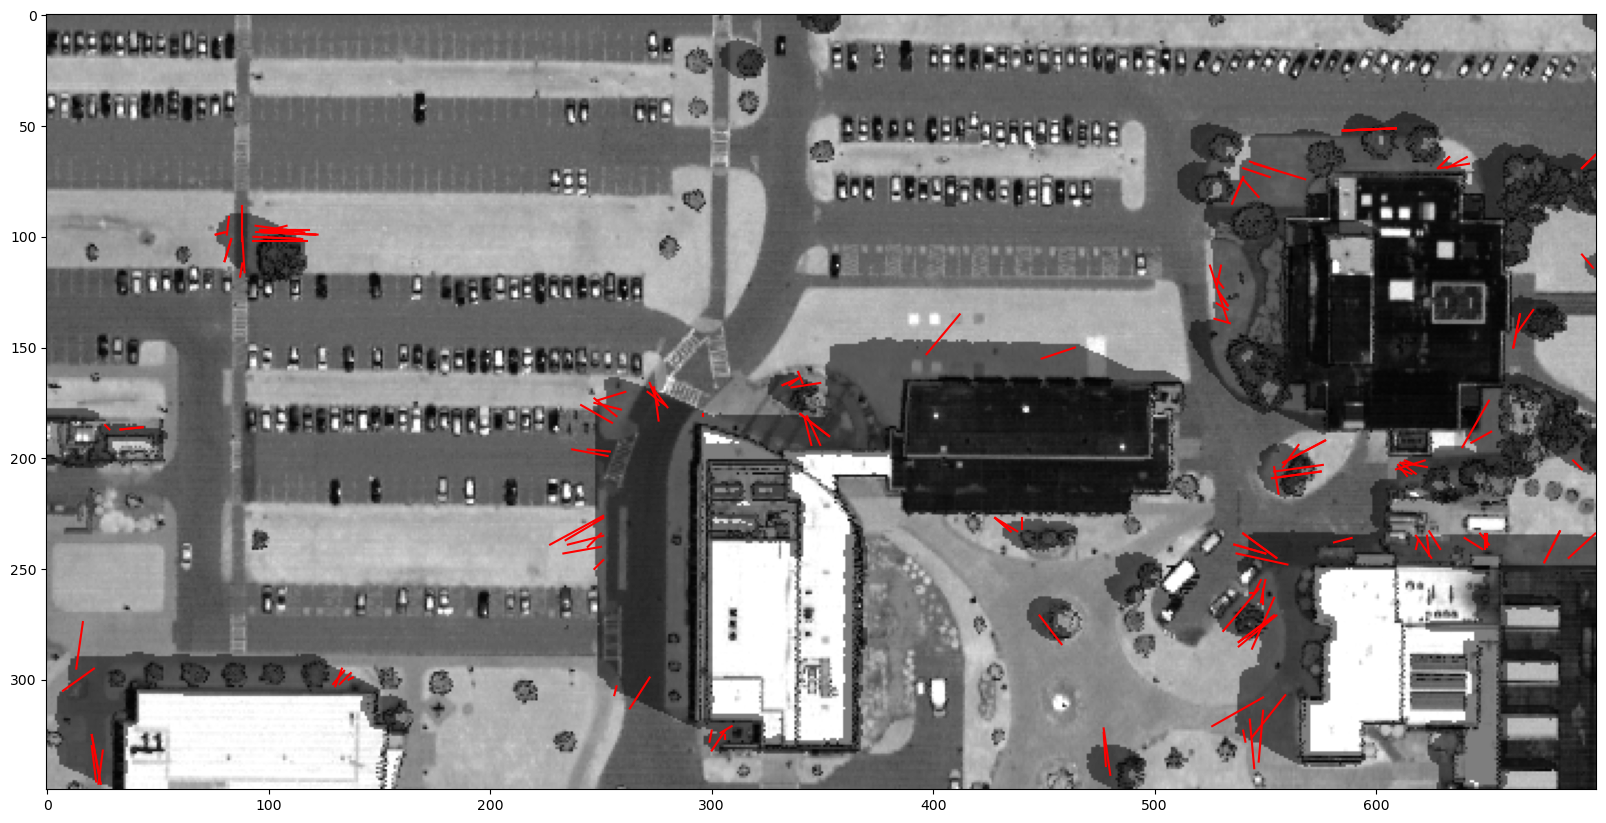

In [29]:
num_examples = 150
training_keys = list(training_data.keys())
example_shadow_pixels = [ training_keys[i] for i in np.random.randint(0, len(training_keys), (num_examples)) ]

correspondence_x_vals = []
correspondence_y_vals = []

for i in range(num_examples):
    correspondence_x_vals.append((example_shadow_pixels[i][1], training_data[example_shadow_pixels[i]][0][1]))
    correspondence_y_vals.append((example_shadow_pixels[i][0], training_data[example_shadow_pixels[i]][0][0]))

shaded_intensity = intensity.copy()
for pixel in shadow_pixels:
    shaded_intensity[pixel] *= 0.5

plt.figure(figsize=(20,20))
plt.imshow(shaded_intensity, cmap='gray')
for i in range(num_examples):
    plt.plot(correspondence_x_vals[i], correspondence_y_vals[i], '-r')
plt.show()